# LSTM-Based Stock Price Prediction
- Implement a Long Short-Term Memory (LSTM) network to capture temporal dependencies in stock price sequences and predict future closing prices.
- LSTM is a special type of RNN that handles long-range dependencies and vanishing gradient problems better.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from financial_metrics import FinancialMetrics
import seaborn as sns

Load Processed Data

In [2]:
df = pd.read_csv("processed_stock_data.csv")
df = df[["Close/Last", "Target_Close_Next_Day"]]
df.head()

,Close/Last,Target_Close_Next_Day
0,220.11,211.99
1,211.99,212.08
2,212.08,216.52
3,216.52,212.42
4,212.42,205.76


Normalize the Data

In [3]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled[:5]

array([[0.64400627, 0.5770151 ],
       [0.5770151 , 0.57775761],
       [0.57775761, 0.61438825],
       [0.61438825, 0.58056266],
       [0.58056266, 0.5256167 ]])

Create Sequences for LSTM
- We use a sliding window approach to build sequences of previous 60 days to predict the next day's closing price.
- sequence_len = 60 (60 past days → 1 next-day prediction)

In [4]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, 0])
        y.append(data[i+sequence_length-1, 1])
    return np.array(X), np.array(y)

sequence_len = 60
X, y = create_sequences(df_scaled, sequence_len)

X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to (samples, timesteps, features)

Split into Train and Test Sets

In [5]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Build LSTM Model

LSTM cells are capable of learning long-term dependencies via gates:
- Forget gate: decides what to throw away
- Input gate: decides what information to store
- Output gate: decides what to output

In [6]:
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(sequence_len, 1)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train the Model

In [7]:
callback = EarlyStopping(patience=20, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[callback],
    verbose=1
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - loss: 0.1364 - val_loss: 0.6365
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0653 - val_loss: 0.3749
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0193 - val_loss: 0.1447
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0142 - val_loss: 0.1150
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0090 - val_loss: 0.1603
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0069 - val_loss: 0.1815
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0079 - val_loss: 0.1738
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0082 - val_loss: 0.1472
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0068 - val_loss: 0.1267
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0061 - val_loss: 0.1206
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0066 - val_loss: 0.1259
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0067 - val_l

Model Evaluation

In [8]:
y_pred = model.predict(X_test)

# Reshape y_test to 2D to inverse scale
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Create dummy arrays with 2 columns to match scaler input
y_pred_dummy = np.zeros((len(y_pred), 2))
y_pred_dummy[:, 1] = y_pred_reshaped[:, 0]

y_test_dummy = np.zeros((len(y_test), 2))
y_test_dummy[:, 1] = y_test_reshaped[:, 0]

y_pred_inv = scaler.inverse_transform(y_pred_dummy)[:, 1]
y_test_inv = scaler.inverse_transform(y_test_dummy)[:, 1]

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
MAE: 8.6757
RMSE: 10.5053
R^2: 0.3706


In [9]:
y_test_series = pd.Series(y_test_inv)
y_pred_series = pd.Series(y_pred_inv)

# Financial metrics
returns = y_pred_series.pct_change().dropna()
fm = FinancialMetrics(risk_free_rate=0.01)
results = fm.evaluate_all(y_test_series, y_pred_series, returns)
display(pd.json_normalize(results))

,Directional Accuracy (%),Cumulative Return (%),Sharpe Ratio,Max Drawdown (%)
0,46.88,-10.24,-2.53,-18.02


Plot Predictions vs True Values

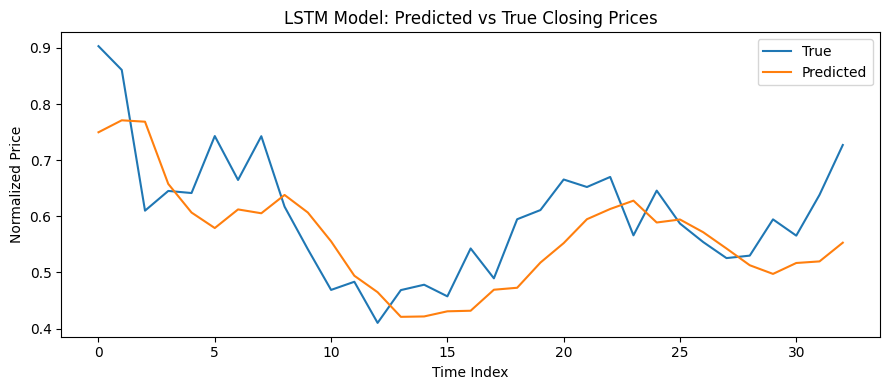

In [10]:
plt.figure(figsize=(9, 4))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM Model: Predicted vs True Closing Prices')
plt.xlabel('Time Index')
plt.ylabel('Normalized Price')
plt.legend()
plt.tight_layout()
plt.show()

Forecast Next 30 Days

In [11]:
last_sequence = df_scaled[-sequence_len:, 0].reshape(1, sequence_len, 1)
future_preds = []

for _ in range(30):
    next_price = model.predict(last_sequence)[0, 0]
    future_preds.append(next_price)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_price]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Inverse scale predictions

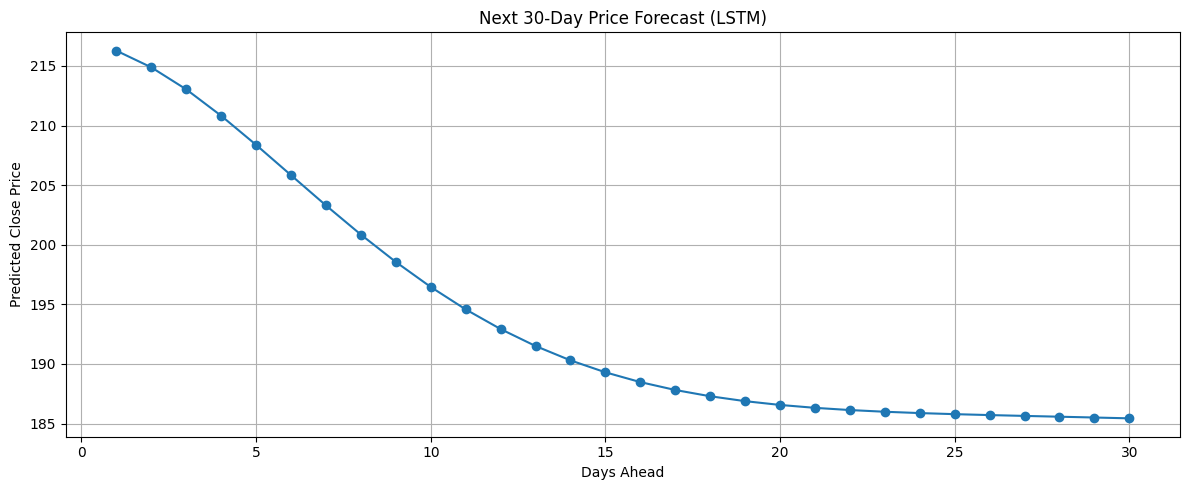

In [12]:
scaled_zeros = np.zeros((30, 2))
scaled_zeros[:, 1] = future_preds
future_prices = scaler.inverse_transform(scaled_zeros)[:, 1]

plt.figure(figsize=(12, 5))
plt.plot(range(1, 31), future_prices, marker='o')
plt.title("Next 30-Day Price Forecast (LSTM)")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()